## Recurrent Neural Networks - Time Series

Sıralı veriler için uygun bir mimari (zaman serileri, ses, dil, video vb).

Not: Bu notebooktaki örneklerde `LSTM` ile `GRU` değiştirilebilir.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as Layers

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
def setupMatplotLib():
    plt.rc('figure', figsize=(10,7))
    plt.rc('font', size=14)
setupMatplotLib()

def plot_history(histories, vertical=False, otherkey='accuracy'):
    plt.rc('figure', figsize=(14,8))
    if vertical:
        p,r = 2,1
    else:
        p,r = 1,2 
    anyPlots = False
    k=1
    for name, history in histories:
        if 'val_loss' in history.history.keys():
            anyPlots = True
            
            ax = plt.subplot(p,r,1)
            val = ax.plot(history.epoch, history.history['val_loss'],
                           '--', label=name.title()+' Val')
            ax.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
                     label=name.title()+' Train')
        elif 'loss' in history.history.keys():
            anyPlots = True
            
            ax = plt.subplot(p,r,1)
            ax.plot(history.epoch, history.history['loss'], label=name.title()+' Train')
            
        if 'val_' + otherkey in history.history.keys():
            k = 2
            anyPlots = True
            
            ax = plt.subplot(p,r,2)
            val = ax.plot(history.epoch, history.history['val_' + otherkey],
                           '--', label=name.title()+' Val')
            ax.plot(history.epoch, history.history[otherkey], color=val[0].get_color(),
                     label=name.title()+' Train')
        elif otherkey in history.history.keys():
            k = 2
            anyPlots = True
            
            ax = plt.subplot(p,r,2)
            ax.plot(history.epoch, history.history[otherkey], label=name.title()+' Train')
        plt.rc('figure', figsize=(10,7))

    if anyPlots:
        for i in range(1,k+1):
            if i == 1:
                key = histories[0][1].model.loss
            else:
                key = otherkey
            ax = plt.subplot(p,r,i)
            ax.set_xlabel('Epochs')
            ax.set_ylabel(key.replace('_',' ').title())
            ax.legend()
        plt.tight_layout()

Oyuncak veri ile başlayalım:

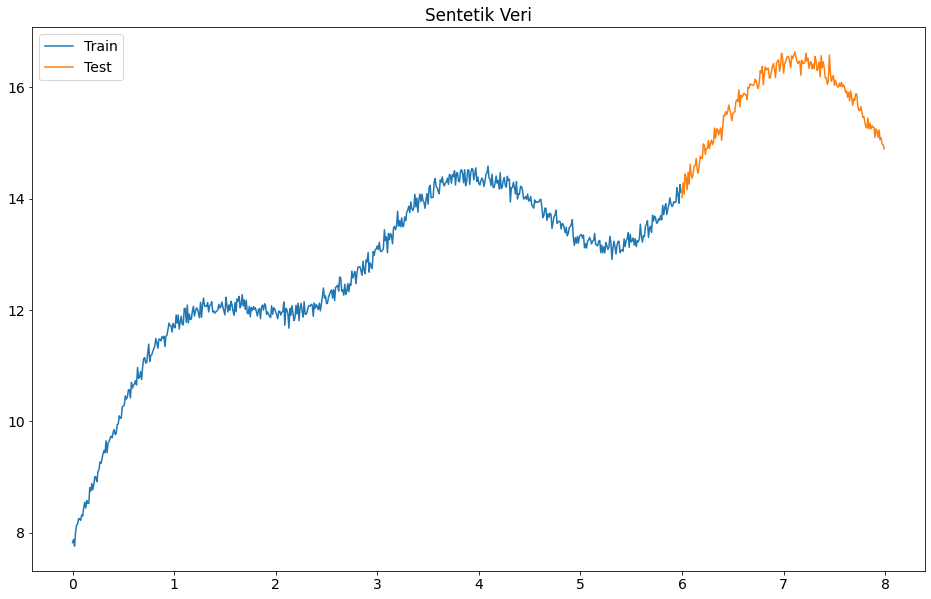

In [52]:
def getSyntheticData(startTime,endTime, tstep = 0.01):
    t = np.arange(startTime,endTime,tstep)
    x1 = np.sin(t)
    x2 = np.sin(2*t)
    x3 = 0.2*(10-(t-6)**2)
    y = 13 + x3 + x1 + x2 + np.random.normal(0,0.1,len(t))
    return np.column_stack([x1,x2,x3]), y, t

Xtrain, yTrain, ttrain = getSyntheticData(0,6)
testStart = 6
testEnd = 8
Xtest, yTest,ttest = getSyntheticData(testStart,testEnd)
plt.figure(figsize=(16,10))
plt.title('Sentetik Veri')
plt.plot(ttrain, yTrain)
plt.plot(ttest, yTest)
plt.legend(['Train','Test'])
plt.show()

Bazı kararlar vermemiz gerekli:
* Neyi tahmin edeceğiz? (t+1, t+10 ...)
* Girdi uzunluğumuz ne kadar olsun. (Bu değişken yapılabilir)
* Tek bir çıktı mı istiyoruz, girdi uzuluğu kadar çıktı mı? Ya da başka bir şey?
* Saklı katmandaki eleman sayısı

Veriyi nasıl öğrenme şekline sokacağız?

In [5]:
windowSize = 10

yTrain = yTrain.reshape((yTrain.shape[0],1))
yTest = yTest.reshape((yTest.shape[0],1))

print('Data')
print(yTrain[:windowSize])
print(yTrain[windowSize])

Data
[[7.84020905]
 [7.96314317]
 [7.71978312]
 [7.82929354]
 [8.06701877]
 [7.95015024]
 [8.26234375]
 [8.1199467 ]
 [8.29347633]
 [8.28266838]]
[8.31248944]


In [12]:
# Öğrenmeye uygun şekle sokuyoruz
# Bu olmadan nasıl kodlardık?
generatorTrain = keras.preprocessing.sequence.TimeseriesGenerator(yTrain, yTrain, length=windowSize, batch_size=1)
generatorTest  = keras.preprocessing.sequence.TimeseriesGenerator(yTest,  yTest,  length=windowSize, batch_size=1)

# Tekrar bakılması gerekebilir
#X = []
#y = []
#for i in range(1,len(yTrain)-windowSize):
#    X.append(yTrain[i:windowSize+i])
#    y.append(yTrain[windowSize+i])

In [13]:
print('Generator')
print(generatorTrain[0][0])
print(generatorTrain[0][1])

Generator
[[[7.84020905]
  [7.96314317]
  [7.71978312]
  [7.82929354]
  [8.06701877]
  [7.95015024]
  [8.26234375]
  [8.1199467 ]
  [8.29347633]
  [8.28266838]]]
[[8.31248944]]


In [14]:
generatorTrain[0][0].shape

(1, 10, 1)

In [15]:
tmpLstm = Sequential()
tmpLstm.add(Layers.LSTM(units=32, return_sequences=False, input_shape=(windowSize, 1)))
tmpLstm.summary()

tmpGru = Sequential()
tmpGru.add(Layers.GRU(units=32, return_sequences=False, input_shape=(windowSize, 1)))
tmpGru.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
Total params: 4,352
Trainable params: 4,352
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3360      
Total params: 3,360
Trainable params: 3,360
Non-trainable params: 0
_________________________________________________________________


In [16]:
rnnSimple = Sequential([
    Layers.GRU(units=32, return_sequences=False, input_shape=(windowSize, 1)),
    Layers.Dropout(0.2),
    Layers.Dense(units = 10,activation='relu'),
    Layers.Dense(units = 1)
])

rnnSimple.compile(optimizer='adam',loss='mean_squared_error')
rnnSimple.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3360      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                330       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 3,701
Trainable params: 3,701
Non-trainable params: 0
_________________________________________________________________


In [17]:
#Batch size arttıralım
generatorTrain = keras.preprocessing.sequence.TimeseriesGenerator(yTrain, yTrain, length=windowSize, batch_size=25)
generatorTest = keras.preprocessing.sequence.TimeseriesGenerator(yTest, yTest, length=windowSize, batch_size=25)
#print(generatorTrain[0][0])

f:\python\python37_64\lib\site-packages\ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


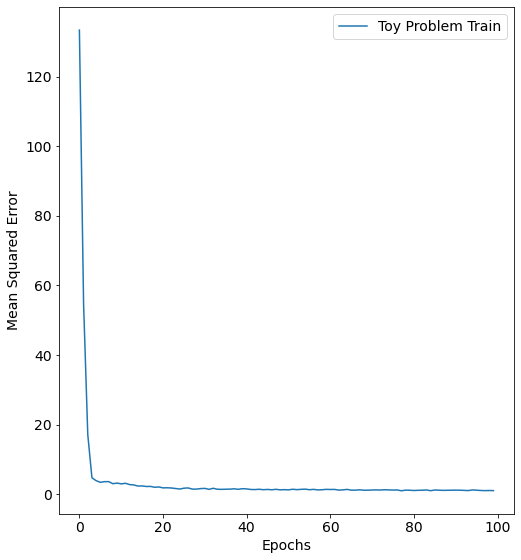

In [18]:
#fit çalışmazsa fit_generator diye düzeltin
history = rnnSimple.fit(generatorTrain, steps_per_epoch=len(generatorTrain), epochs=100, verbose=0)

plot_history([('Toy Problem',history)])

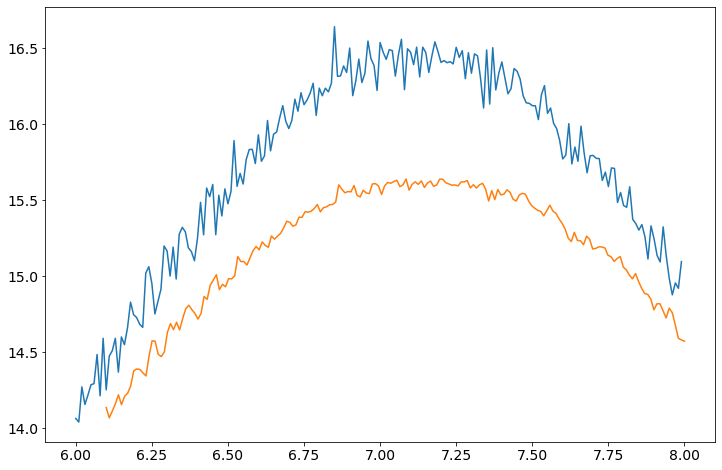

In [19]:
yp = rnnSimple.predict(generatorTest)
plt.figure(figsize=(12,8))
plt.plot(np.arange(testStart,testEnd,0.01), yTest)
plt.plot(np.linspace(testStart + 0.01*windowSize,testEnd,len(yp)),yp)

GRU ve LSTM gibi RNN mimarilerinin içerisinde satüre olabilecek fonksiyonlar mevcut. Bu yüzden veriyi makul bir şekilde scale etmek gerekebilir. Bu eğitim kümesinden (örneğin z-normalization) ya da domain bilgisinden (beklenen en yüksek değere oranla) gelebilir.

In [20]:
yTrainScaled = yTrain/13
yTestScaled = yTest/13

generatorTrain = keras.preprocessing.sequence.TimeseriesGenerator(yTrainScaled, yTrainScaled, length=windowSize, batch_size=25)
generatorTest = keras.preprocessing.sequence.TimeseriesGenerator(yTestScaled, yTestScaled, length=windowSize, batch_size=25)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                3360      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 3,701
Trainable params: 3,701
Non-trainable params: 0
_________________________________________________________________


f:\python\python37_64\lib\site-packages\ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


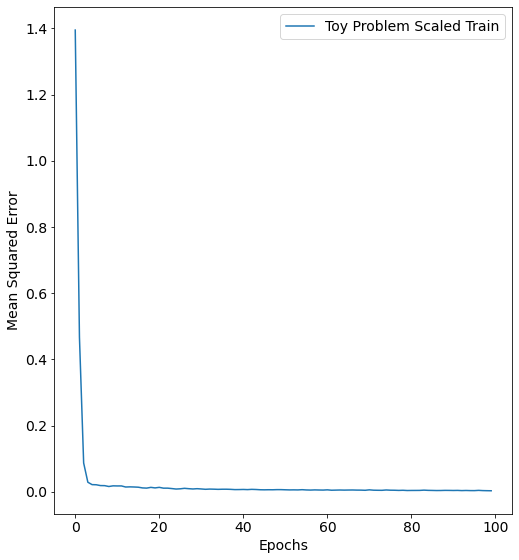

In [21]:
rnnSimpleScaled = Sequential()
rnnSimpleScaled.add(Layers.GRU(units=32, return_sequences=False, input_shape=(windowSize, 1)))
rnnSimpleScaled.add(Layers.Dropout(0.2))
rnnSimpleScaled.add(Layers.Dense(units = 10,activation='relu'))
rnnSimpleScaled.add(Layers.Dense(units = 1))

rnnSimpleScaled.compile(optimizer='adam',loss='mean_squared_error')
rnnSimpleScaled.summary()

history = rnnSimpleScaled.fit(generatorTrain, steps_per_epoch=len(generatorTrain), epochs=100, verbose=0)

plot_history([('Toy Problem Scaled',history)])

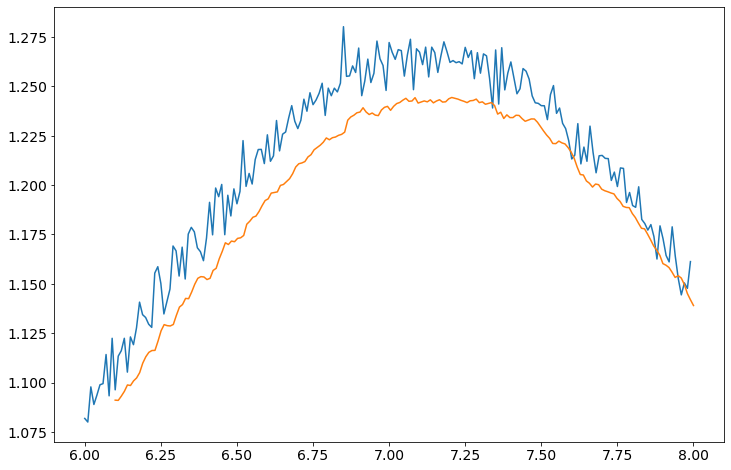

In [22]:
yp = rnnSimpleScaled.predict(generatorTest)
plt.figure(figsize=(12,8))
plt.plot(np.arange(testStart,testEnd,0.01), yTestScaled)
plt.plot(np.linspace(testStart + 0.01*windowSize,testEnd,len(yp)),yp)

Bazen de doğrudan değeri tahmin etmek yerine, **verideki değişimi tahmin etmek** isteriz. Bu biraz daha robust çalışır.

[0.00945647] [0.00945647]


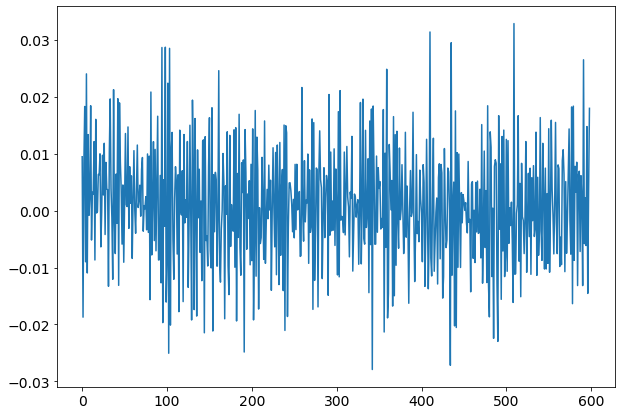

In [54]:
yTrainDelta = np.diff(yTrainScaled,axis=0).reshape((-1,1)) #ytrainden 1 eksik
yTestDelta = np.diff(yTestScaled,axis=0).reshape((-1,1)) #ytrainden 1 eksik
print(yTrainDelta[0],yTrainScaled[1]-yTrainScaled[0])
plt.plot(yTrainDelta)

In [55]:
#Not: diffte bir nokta kaybettik
#train x(t-1),x(t),tahmin x(t+1)-x(t)
yTrainDelta = np.vstack((0,yTrainDelta)) #doldurmak için kullanıyoruz
yTestDelta = np.vstack((0,yTestDelta)) 

generatorTrain = keras.preprocessing.sequence.TimeseriesGenerator(yTrainScaled, yTrainDelta, length=windowSize, batch_size=1)
generatorTest  = keras.preprocessing.sequence.TimeseriesGenerator(yTestScaled, yTestDelta, length=windowSize, batch_size=1)

#generatorTrain = keras.preprocessing.sequence.TimeseriesGenerator(yTrainDelta, yTrainDelta, length=windowSize, batch_size=1)
#generatorTest  = keras.preprocessing.sequence.TimeseriesGenerator(yTestDelta, yTestDelta, length=windowSize, batch_size=1)

print(yTrainScaled[:windowSize])
print(yTrainDelta[windowSize],yTrainScaled[windowSize]-yTrainScaled[windowSize-1])
print(generatorTrain[0][0])
print(generatorTrain[0][1])

#generatorTrain = keras.preprocessing.sequence.TimeseriesGenerator(yTrainScaled, yTrainDelta, length=windowSize, batch_size=32)
#generatorTest  = keras.preprocessing.sequence.TimeseriesGenerator(yTestScaled, yTestDelta, length=windowSize, batch_size=32)

generatorTrain = keras.preprocessing.sequence.TimeseriesGenerator(yTrainDelta, yTrainDelta, length=windowSize, batch_size=32)
generatorTest = keras.preprocessing.sequence.TimeseriesGenerator(yTestDelta, yTestDelta, length=windowSize, batch_size=32)

[[0.603093  ]
 [0.61254947]
 [0.59382947]
 [0.60225335]
 [0.62053991]
 [0.61155002]
 [0.6355649 ]
 [0.62461128]
 [0.63795972]
 [0.63712834]]
[0.00229393] [0.00229393]
[[[0.603093  ]
  [0.61254947]
  [0.59382947]
  [0.60225335]
  [0.62053991]
  [0.61155002]
  [0.6355649 ]
  [0.62461128]
  [0.63795972]
  [0.63712834]]]
[[0.00229393]]


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 32)                3360      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 3,701
Trainable params: 3,701
Non-trainable params: 0
_________________________________________________________________


f:\python\python37_64\lib\site-packages\ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


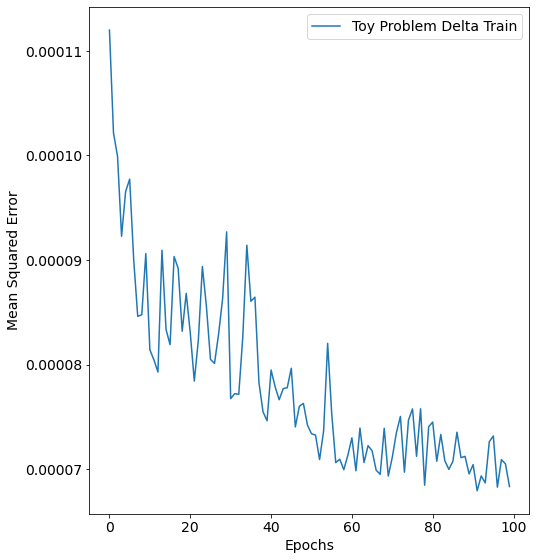

In [34]:
rnnSimpleDelta = Sequential()
rnnSimpleDelta.add(Layers.GRU(units=32, return_sequences=False, input_shape=(windowSize, 1)))
rnnSimpleDelta.add(Layers.Dropout(0.2))
rnnSimpleDelta.add(Layers.Dense(units = 10,activation='relu'))
rnnSimpleDelta.add(Layers.Dense(units = 1))

rnnSimpleDelta.compile(optimizer='adam',loss='mean_squared_error')
rnnSimpleDelta.summary()

history = rnnSimpleDelta.fit(generatorTrain, steps_per_epoch=len(generatorTrain), epochs=100, verbose=0)

plot_history([('Toy Problem Delta',history)])

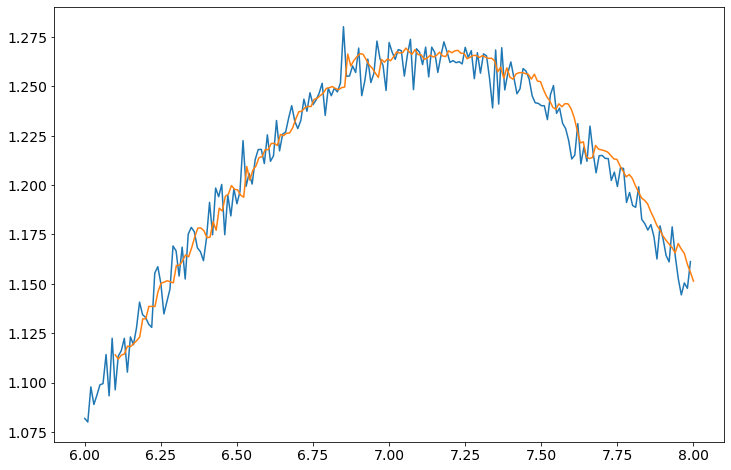

In [35]:
ypd = rnnSimpleDelta.predict(generatorTest)
yp = ypd + yTestScaled[windowSize-1:-1]
plt.figure(figsize=(12,8))
plt.plot(np.arange(testStart,testEnd,0.01), yTestScaled) #TODO
plt.plot(np.linspace(testStart + 0.01*windowSize,testEnd,len(yp)),yp)

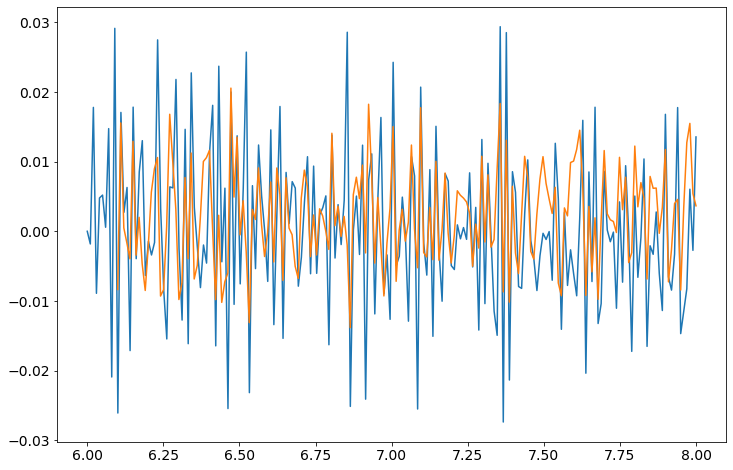

In [36]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(testStart,testEnd,len(yTestDelta)), yTestDelta)
plt.plot(np.linspace(testStart + 0.01*windowSize,testEnd,len(ypd)),ypd)

İkisini birleştirelim

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 32)                3456      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 3,797
Trainable params: 3,797
Non-trainable params: 0
_________________________________________________________________


f:\python\python37_64\lib\site-packages\ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


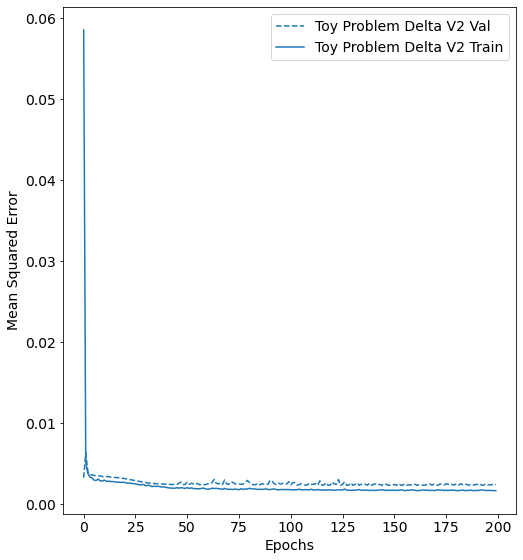

In [57]:
yTrainDelta = np.diff(yTrainScaled,axis=0).reshape((-1,1)) #ytrainden 1 eksik
yTestDelta = np.diff(yTestScaled,axis=0).reshape((-1,1)) #ytrainden 1 eksik

#Not: diffte bir nokta kaybettik, sonuncuyu atıyoru<
#train x(t-1),x(t),tahmin x(t+1)-x(t)
yTrainDelta = np.vstack((0,yTrainDelta))*5 #doldurmak için kullanıyoruz
yTestDelta = np.vstack((0,yTestDelta))*5 
yTrainComb = np.hstack((yTrainScaled,yTrainDelta))
yTestComb = np.hstack((yTestScaled,yTestDelta))

generatorTrain = keras.preprocessing.sequence.TimeseriesGenerator(yTrainComb, yTrainDelta, length=windowSize, batch_size=32)
generatorTest = keras.preprocessing.sequence.TimeseriesGenerator(yTestComb, yTestDelta, length=windowSize, batch_size=32)

rnnSimpleDelta = Sequential()
rnnSimpleDelta.add(Layers.GRU(units=32, return_sequences=False, input_shape=(windowSize, 2)))
rnnSimpleDelta.add(Layers.Dropout(0.2))
rnnSimpleDelta.add(Layers.Dense(units = 10,activation='relu'))
rnnSimpleDelta.add(Layers.Dense(units = 1))

rnnSimpleDelta.compile(optimizer='adam',loss='mean_squared_error')
rnnSimpleDelta.summary()

history = rnnSimpleDelta.fit(generatorTrain, steps_per_epoch=len(generatorTrain), epochs=200, verbose=0,
                             validation_data=generatorTest)

plot_history([('Toy Problem Delta V2',history)])

In [58]:
print(yTestScaled.shape,yTestDelta.shape,yTestComb.shape)

(200, 1) (200, 1) (200, 2)


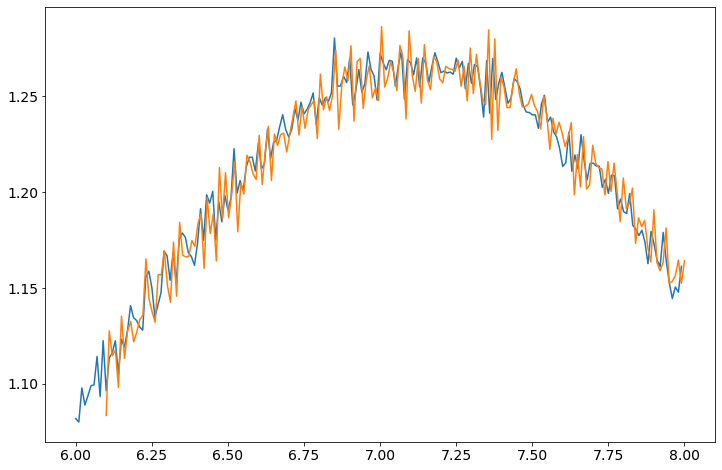

In [59]:
yp = rnnSimpleDelta.predict(generatorTest)/5+yTestScaled[windowSize:]
plt.figure(figsize=(12,8))
plt.plot(np.arange(testStart,testEnd,0.01), yTestScaled)
plt.plot(np.linspace(testStart + 0.01*windowSize,testEnd,len(yp)),yp)

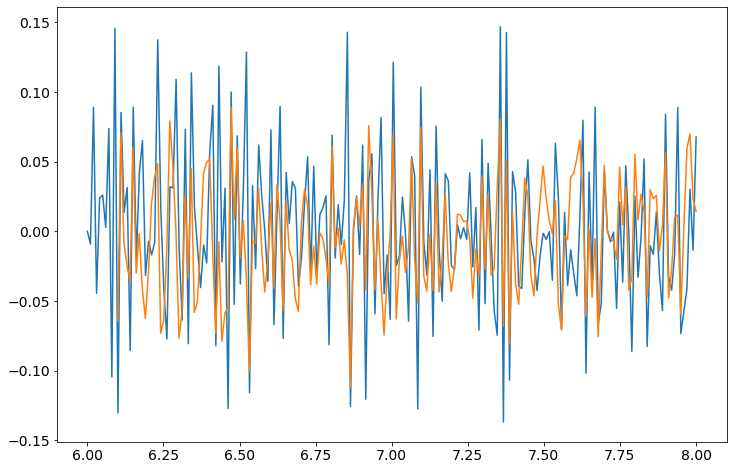

In [60]:
yp = rnnSimpleDelta.predict(generatorTest)
plt.figure(figsize=(12,8))
plt.plot(np.linspace(testStart,testEnd,len(yTestDelta)), yTestDelta)
plt.plot(np.linspace(testStart + 0.01*windowSize,testEnd,len(yp)),yp)

In [61]:
rnnSimpleDelta.evaluate(generatorTest)

6/6 [==============================] - 0s 2ms/step - loss: 0.0024


0.0023571946658194065

İkisini birden tahmin edip kıyaslayalım

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 64)                13056     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 66        
Total params: 15,202
Trainable params: 15,202
Non-trainable params: 0
_________________________________________________________________


f:\python\python37_64\lib\site-packages\ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


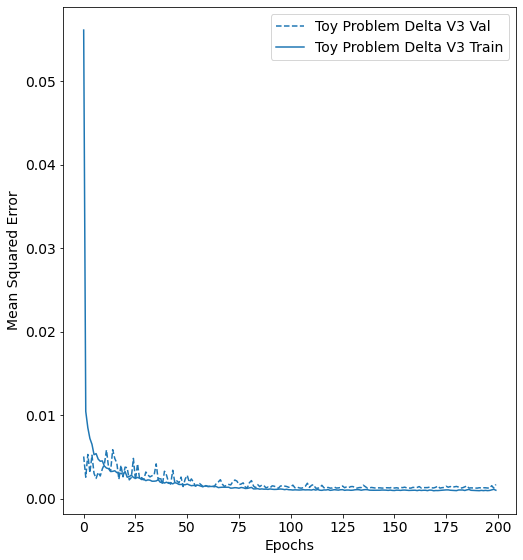

In [62]:
generatorTrain = keras.preprocessing.sequence.TimeseriesGenerator(yTrainComb, yTrainComb, length=windowSize, batch_size=32)
generatorTest  = keras.preprocessing.sequence.TimeseriesGenerator(yTestComb, yTestComb, length=windowSize, batch_size=32)

rnnSimpleDeltaBoth = Sequential()
rnnSimpleDeltaBoth.add(Layers.GRU(units=64, return_sequences=False, input_shape=(windowSize, 2)))
rnnSimpleDeltaBoth.add(Layers.Dropout(0.2))
rnnSimpleDeltaBoth.add(Layers.Dense(units = 32,activation='relu'))
rnnSimpleDeltaBoth.add(Layers.Dense(units = 2))

rnnSimpleDeltaBoth.compile(optimizer='adam',loss='mean_squared_error')
rnnSimpleDeltaBoth.summary()

history = rnnSimpleDeltaBoth.fit(generatorTrain, steps_per_epoch=len(generatorTrain), epochs=200, verbose=0,
                             validation_data=generatorTest)

plot_history([('Toy Problem Delta V3',history)])

In [63]:
rnnSimpleDeltaBoth.evaluate(generatorTest)

6/6 [==============================] - 0s 2ms/step - loss: 0.0017


0.0016828033840283751

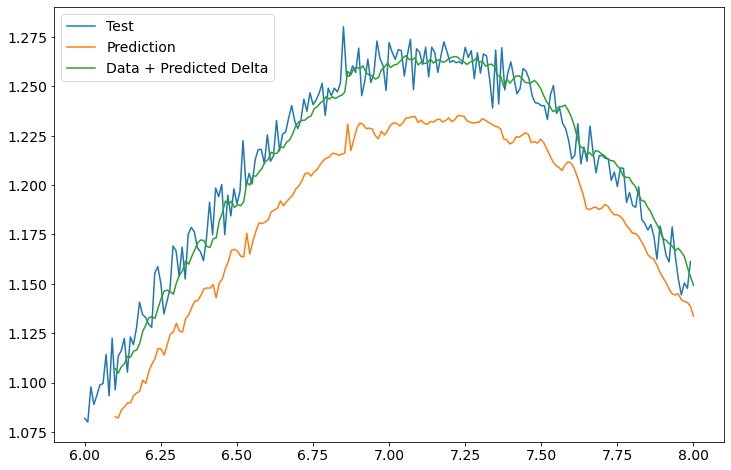

In [64]:
# Plot both 
yp = rnnSimpleDeltaBoth.predict(generatorTest)
deltaPreds = yp[:,1]
regPreds = yp[:,0]
sumDeltaPreds = deltaPreds/5+yTestScaled[windowSize-1:-1,0]
plt.figure(figsize=(12,8))
plt.plot(np.arange(testStart,testEnd,0.01), yTestScaled)
plt.plot(np.linspace(testStart + 0.01*windowSize,testEnd,len(yp)),regPreds)
plt.plot(np.linspace(testStart + 0.01*windowSize,testEnd,len(yp)),sumDeltaPreds)
plt.legend(['Test','Prediction','Data + Predicted Delta'])

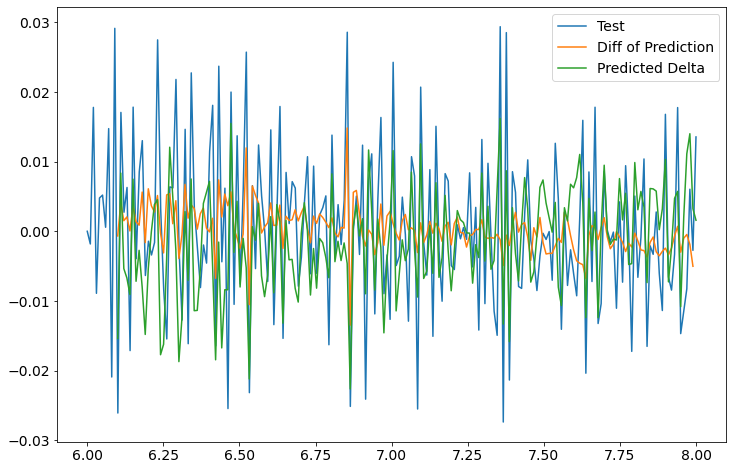

In [65]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(testStart,testEnd,len(yTestDelta)), yTestDelta/5.)
plt.plot(np.linspace(testStart + 0.01*windowSize,testEnd-0.01,len(yp)-1),np.diff(regPreds))
plt.plot(np.linspace(testStart + 0.01*windowSize,testEnd,len(yp)),deltaPreds/5.)
plt.legend(['Test','Diff of Prediction','Predicted Delta'])

**Egzersiz:** 
Veriler arasında *opsd_germany_daily.csv* isimli bir dosya var. Bu dosyada Almanyanın günlük toplam enerji harcaması, rüzgar enerjisi üretimi, güneş enerjisi üretimi ve ikisinin toplamı mevcut. Ancak rüzgar ve güneş enerjisi beraber, 2012 yılından itibaren tutuluyor. 

Bu verilerden birbirleriyle alakalı bir kaç problem tanımlayabiliriz:
* Ertesi gün (ya da ertesi hafta) rüzgar ve güneş enerjisinden karşılanamayacak gereksinim tahmini
* Ertesi gün toplam harcama tahmini
* Ertesi gün rüzgar enerjisi veya güneş enerjisi üretme tahmini
* Ertesi gün toplam ya da rüzgar + güneş ile üretilemeyecek enerji gereksinimi belirli bir değerin üzerine çıkacak mı?

Bir problem seçip bir yapay öğrenme yaklaşımı ile çözmeye çalışın. Aşağıdaki noktalara dikkat edin.
* Geçmişte ne kadar geriye bakmalıyız?
* Sezonsallık/zaman bilgisi dahil etmeli miyiz?
* Nasıl test edebiliriz? Çapraz geçerlilik uygulayabilir miyiz?

In [47]:
import pandas as pd
raw_data = pd.read_csv('./data/opsd_germany_daily.csv', parse_dates=[0], index_col=0)

data = raw_data.loc['2012-01-01':]
data.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2012-01-01,948.128,227.465,6.587,234.052
2012-01-02,1269.581,207.327,6.574,213.901
2012-01-03,1334.745,473.468,24.679,498.147
2012-01-04,1347.136,499.804,14.681,514.485
2012-01-05,1376.658,523.851,5.071,528.922


Consumption tahmini:  
* 2012-2016: train  
* 2016-2017: test  

In [48]:
trainFrame = data.loc[:'2016-12-31']
testFrame  = data.loc['2017-01-01':]

<AxesSubplot:xlabel='Date'>

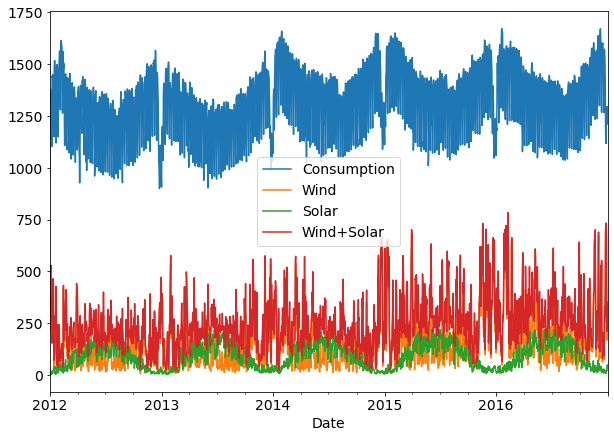

In [49]:
trainFrame.plot()

<AxesSubplot:xlabel='Date'>

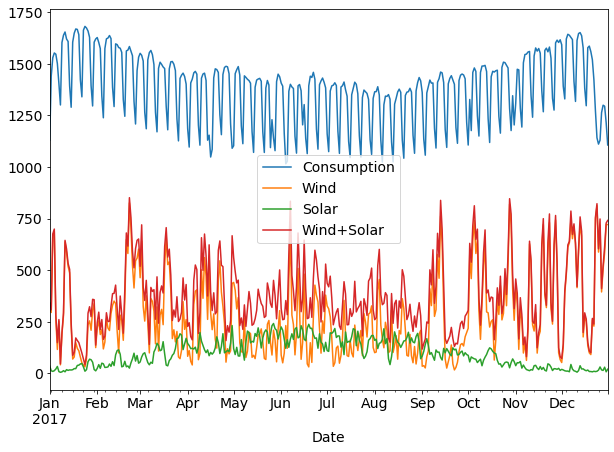

In [50]:
testFrame.plot()

In [103]:
# Feature Engineering
from sklearn.preprocessing import MinMaxScaler

def getRaw(inputFrame):
    return inputFrame[['Consumption', 'Wind', 'Solar']].fillna(method='ffill').to_numpy()

def getDatesOut(inputFrame):
    days = inputFrame.index.day.to_numpy()/31.
    months = inputFrame.index.month.to_numpy()/12.
    years = inputFrame.index.year.to_numpy() - 2012
    ret = np.vstack((days,months,years)).T
    return ret

def getDiffs(inputArray):
    ret = np.diff(inputArray,axis=0)
    ret = np.vstack((np.zeros((1,ret.shape[1])),ret))
    return ret

scaler = MinMaxScaler(feature_range=[0.01,0.99])
fTrain = getRaw(trainFrame)
fTrain = scaler.fit_transform(fTrain)
fTrain = np.hstack((fTrain,getDiffs(fTrain)))
fTrain = np.hstack((fTrain,getDatesOut(trainFrame)))

fTest =  getRaw(testFrame)
fTest = scaler.fit_transform(fTest)
fTest = np.hstack((fTest,getDiffs(fTest)))
fTest = np.hstack((fTest,getDatesOut(testFrame)))

print(fTrain.shape)
yTrain = fTrain[:,0]
yTest = fTest[:,0]

(1827, 9)


In [104]:
fTrain

array([[0.07127561, 0.30059434, 0.02987574, ..., 0.03225806, 0.08333333,
        0.        ],
       [0.47907729, 0.27410924, 0.0298198 , ..., 0.06451613, 0.08333333,
        0.        ],
       [0.56174563, 0.62413263, 0.10772633, ..., 0.09677419, 0.08333333,
        0.        ],
       ...,
       [0.51246229, 0.22198996, 0.18617504, ..., 0.93548387, 1.        ,
        4.        ],
       [0.50630568, 0.31610295, 0.21042697, ..., 0.96774194, 1.        ,
        4.        ],
       [0.40674946, 0.4158015 , 0.15033072, ..., 1.        , 1.        ,
        4.        ]])

In [67]:
windowSize = 10
generatorTrain = keras.preprocessing.sequence.TimeseriesGenerator(fTrain, yTrain, 
                                                                  length=windowSize, batch_size=128, shuffle=True)
generatorTest  = keras.preprocessing.sequence.TimeseriesGenerator(fTest,  yTest,  length=windowSize, batch_size=1)

In [68]:
# Model building
forecastModel = Sequential()
#forecastModel.add(Layers.Dense(16,activation='relu'))
#forecastModel.add(Layers.TimeDistributed(Layers.Dense(16,activation='relu')))
#forecastModel.add(Layers.Conv1D(10,3,activation='relu'))
#forecastModel.add(Layers.BatchNormalization())
forecastModel.add(Layers.GRU(128))
forecastModel.add(Layers.Dropout(0.5))
forecastModel.add(Layers.Dense(16,activation='relu'))
forecastModel.add(Layers.Dense(1))

forecastModel.compile(loss='mse',optimizer='adam', metrics = ['mae'])

In [69]:
hist = forecastModel.fit(generatorTrain, epochs=200, verbose=0, steps_per_epoch=len(generatorTrain),
                         validation_data=generatorTest)

In [70]:
forecastModel.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 128)               53376     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 55,457
Trainable params: 55,457
Non-trainable params: 0
_________________________________________________________________


f:\python\python37_64\lib\site-packages\ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


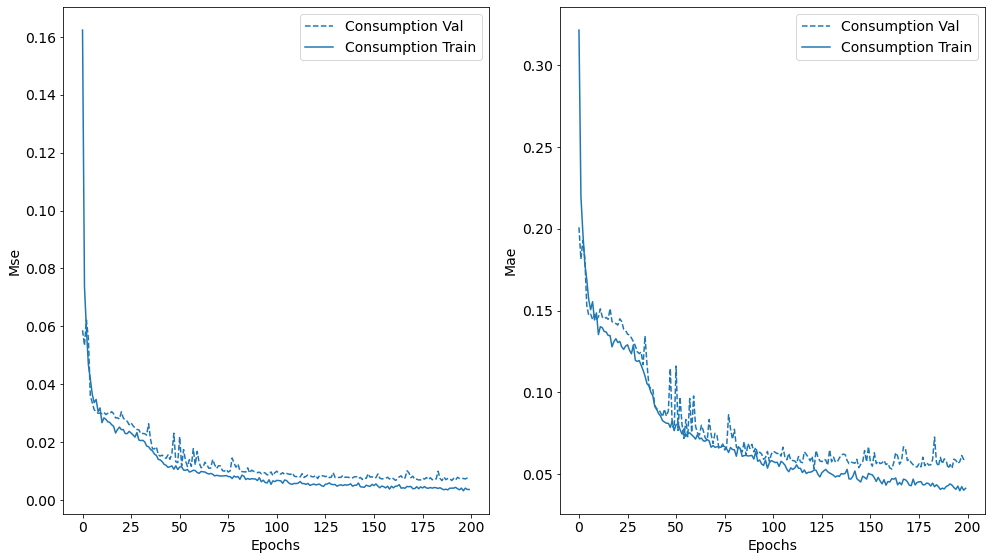

In [71]:
plot_history([('Consumption',hist)], otherkey='mae')

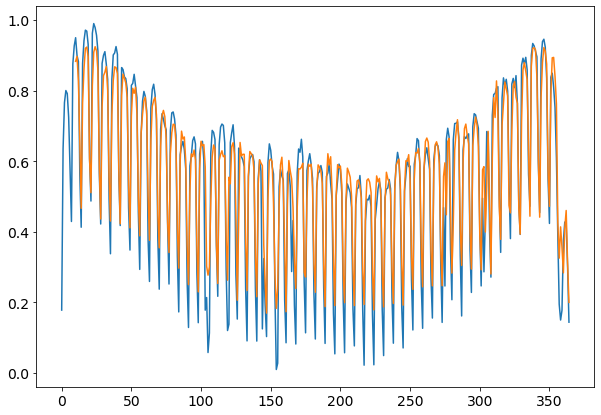

In [72]:
preds = forecastModel.predict(generatorTest)
plt.plot(np.arange(len(yTest)), yTest)
plt.plot(np.arange(windowSize,len(preds)+windowSize),preds)

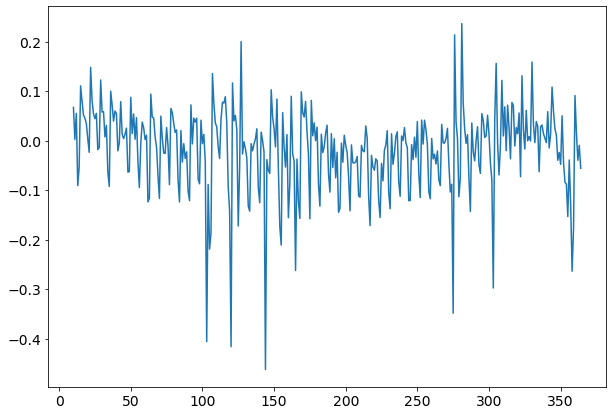

In [73]:
plt.plot(np.arange(windowSize,len(preds)+windowSize), yTest[windowSize:,np.newaxis]-preds)

In [74]:
forecastModel.evaluate(generatorTest)

355/355 [==============================] - 1s 2ms/step - loss: 0.0076 - mae: 0.0605


[0.007613070774823427, 0.060506224632263184]

Difference target

In [76]:
yTrainDiff = fTrain[:,3]
yTestDiff = fTest[:,3]

f:\python\python37_64\lib\site-packages\ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


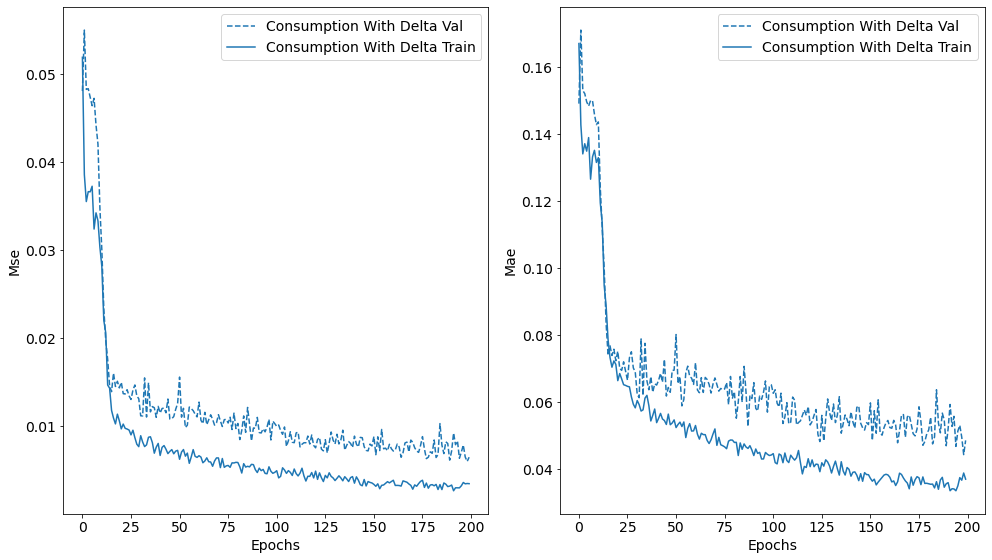

In [77]:
windowSize = 10
generatorTrainDelta = keras.preprocessing.sequence.TimeseriesGenerator(fTrain, yTrainDiff, 
                                                                  length=windowSize, batch_size=128,shuffle=True)
generatorTestDelta  = keras.preprocessing.sequence.TimeseriesGenerator(fTest,  yTestDiff,  length=windowSize, batch_size=1)

forecastModelDelta = Sequential()
forecastModelDelta.add(Layers.GRU(128))
forecastModelDelta.add(Layers.Dropout(0.5))
forecastModelDelta.add(Layers.Dense(16,activation='relu'))
forecastModelDelta.add(Layers.Dense(1))
forecastModelDelta.compile(loss='mse',optimizer='adam', metrics = ['mae'])
hist = forecastModelDelta.fit(generatorTrainDelta, epochs=200, verbose=0, steps_per_epoch=len(generatorTrain),
                         validation_data=generatorTestDelta)

plot_history([('Consumption With Delta',hist)], otherkey='mae')

In [78]:
forecastModelDelta.evaluate(generatorTestDelta)

355/355 [==============================] - 1s 2ms/step - loss: 0.0065 - mae: 0.0486


[0.006493847817182541, 0.048599034547805786]

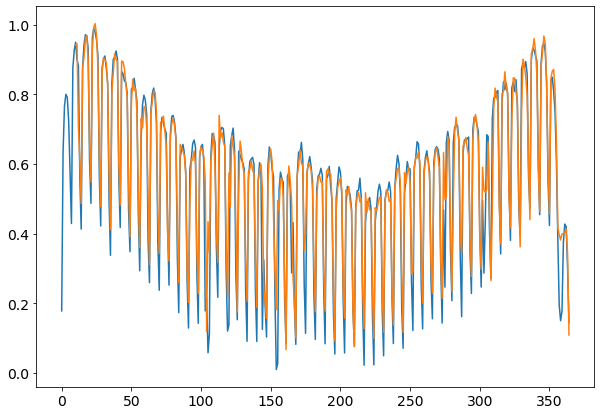

In [79]:
ypd = forecastModelDelta.predict(generatorTestDelta)
yp = ypd + yTest[windowSize-1:-1,None]
plt.plot(np.arange(len(yTest)), yTest)
plt.plot(np.arange(windowSize,len(yp)+windowSize),yp)

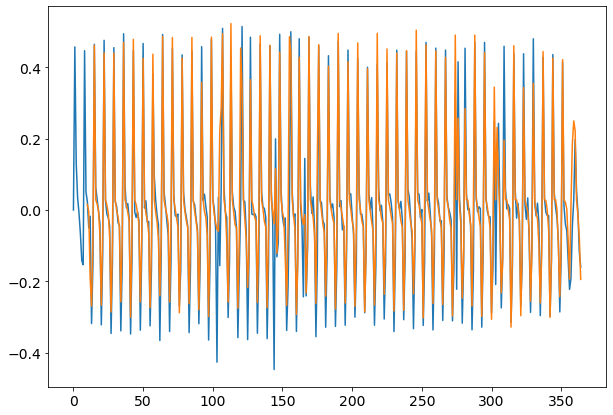

In [80]:
plt.plot(np.arange(len(yTest)), yTestDiff)
plt.plot(np.arange(windowSize,len(ypd)+windowSize),ypd)

Daha detaylı örnek: https://www.tensorflow.org/tutorials/structured_data/time_series

Time Series Cross Validation?

In [88]:
from sklearn.model_selection import TimeSeriesSplit

In [96]:
tscv = TimeSeriesSplit(max_train_size=None, # bunu kullanarak kayan pencere şekli yaratabiliriz
                       n_splits = 5)
tscv2 = TimeSeriesSplit(max_train_size=30, # bunu kullanarak kayan pencere şekli yaratabiliriz
                       n_splits = 5)

In [91]:
x = np.random.random((180,2))
y = np.random.random((180,1))

In [94]:
# 180 veri noktası, n = 5 diyince 5 train durumu, veriyi 6ya bölüyor. 1/6sı hep test, gerisi tamamen training
for train_index, test_index in tscv.split(x):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] TEST: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59] TEST: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89] TEST: [ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22

In [97]:
# 180 veri noktası, n = 5 diyince 5 train durumu, veriyi 6ya bölüyor. 1/6sı hep test, gerisi max train size ile 
# ben 30 verdim, 1/6ya eşşit ayni her train de 1 aylık veri var (her testte olduğu gibi)
for train_index, test_index in tscv2.split(x):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] TEST: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
TRAIN: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59] TEST: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89]
TRAIN: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89] TEST: [ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
TRAIN: [ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119] TEST: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149]
TRAIN: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 1

In [112]:
fAll = np.vstack((fTrain,fTest))
# 2012den 2017ye verimiz var. 1 yıl train 1 yıl test yapalım (train_size = 365)
# aslında bu problem için bütün geçmiş faydalı olacak gibi gözüküyor, o yüzden max_train_size = None daha mantıklı
# 5 yılımız var, n_splits = 4
tscv = TimeSeriesSplit(max_train_size=None, # bunu kullanarak kayan pencere şekli yaratabiliriz
                       n_splits = 4)
windowSize = 10
epochs = 50

def simpleGruModel():
    model = Sequential()
    model.add(Layers.GRU(128))
    model.add(Layers.Dropout(0.5))
    model.add(Layers.Dense(16,activation='relu'))
    model.add(Layers.Dense(1))
    model.compile(loss='mse',optimizer='adam', metrics = ['mae'])
    
    return model

models  = []
modelsD = []

hists = []
histsD = []

for train_index, test_index in tscv.split(fAll):
    
    #n = len(train_index)
    #split =1/6.
    #valLimit = int(n*split)
    #xTrain = fAll[:-valLimit]
    #xVal = fAll[-valLimit:]
    
    xTrain  = fAll[train_index,:]
    yTrain  = xTrain[:,0]
    yTrainD = xTrain[:,3]
    
    xTest   = fAll[test_index,:]
    yTest   = xTest[:,0]
    yTestD  = xTest[:,3]
    
    generatorTrain = keras.preprocessing.sequence.TimeseriesGenerator(xTrain, yTrain, length=windowSize, 
                                                                           batch_size=128, shuffle=True)
    generatorTest  = keras.preprocessing.sequence.TimeseriesGenerator(xTest,  yTest,  length=windowSize, 
                                                                      batch_size=1)

    generatorTrainDelta = keras.preprocessing.sequence.TimeseriesGenerator(xTrain, yTrainD,length=windowSize, 
                                                                           batch_size=128, shuffle=True)
    generatorTestDelta  = keras.preprocessing.sequence.TimeseriesGenerator(xTest,  yTestD,  length=windowSize, 
                                                                           batch_size=1)

    forecastModelCV = simpleGruModel()
    hist = forecastModelCV.fit(generatorTrain, epochs=epochs, verbose=0, steps_per_epoch=len(generatorTrain),
                             validation_data=generatorTest) #, validation_split=1/6.
    
    forecastModelDeltaCV = simpleGruModel()
    histDelta = forecastModelDeltaCV.fit(generatorTrainDelta, epochs=epochs, verbose=0, steps_per_epoch=len(generatorTrainDelta),
                         validation_data=generatorTestDelta)
    
    models.append(forecastModelCV)
    hists.append(hist)
    
    modelsD.append(forecastModelDeltaCV)
    histsD.append(histDelta)
    
    #forecastModelCV.evaluate(generatorTest)


In [113]:
a = [(str(i),hists[i]) for i in range(len(hists))]
a

[('0', <tensorflow.python.keras.callbacks.History at 0x21027118048>),
 ('1', <tensorflow.python.keras.callbacks.History at 0x2102f035708>),
 ('2', <tensorflow.python.keras.callbacks.History at 0x21035bf9448>),
 ('3', <tensorflow.python.keras.callbacks.History at 0x2103c7be448>)]

f:\python\python37_64\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
f:\python\python37_64\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
f:\python\python37_64\lib\site-packages\ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

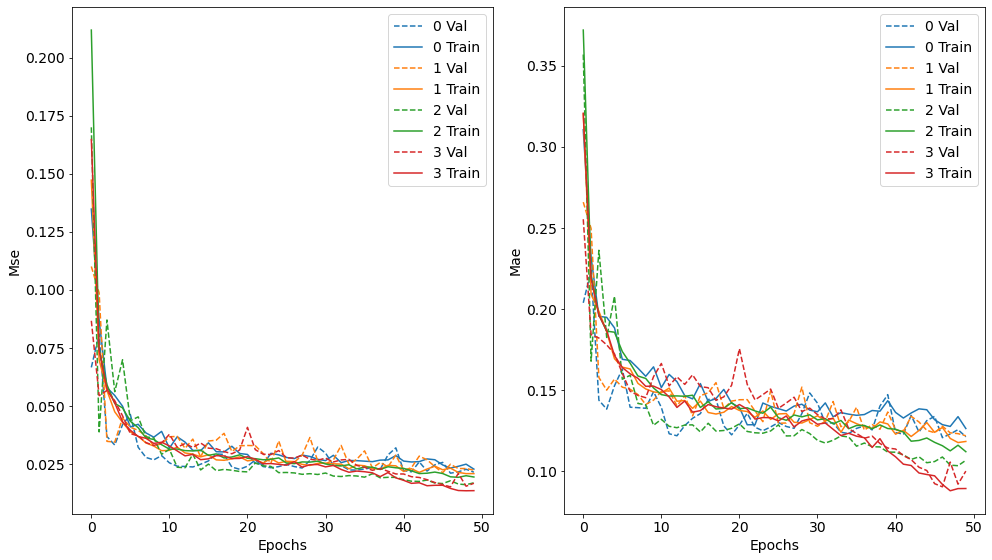

In [114]:
plot_history(a,otherkey='mae')

f:\python\python37_64\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
f:\python\python37_64\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
f:\python\python37_64\lib\site-packages\ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

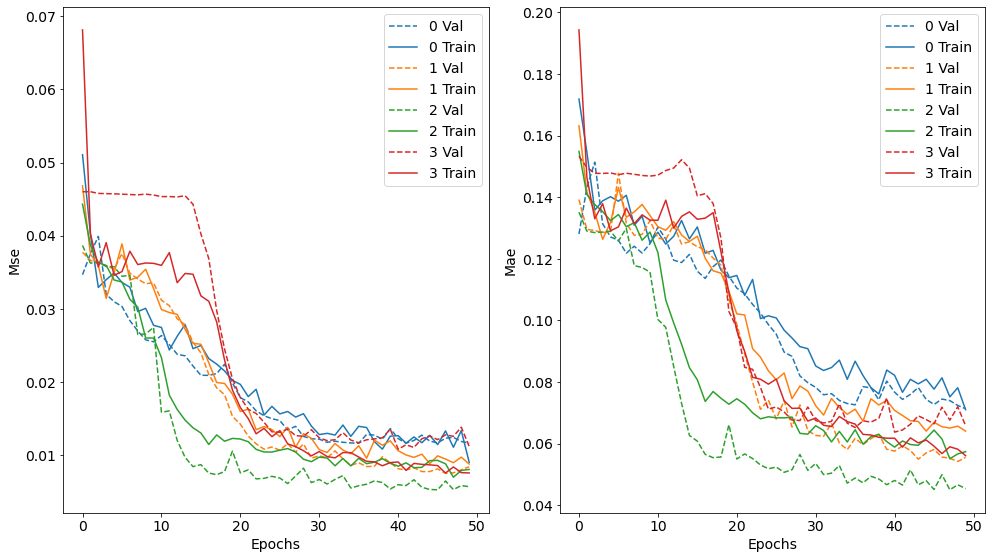

In [115]:
b = [(str(i),histsD[i]) for i in range(len(histsD))]
plot_history(b,otherkey='mae')